In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
%cd /gdrive/My\ Drive/butterflies

/gdrive/My Drive/butterflies


#Data visualization

In [4]:
G = nx.read_weighted_edgelist('SS-Butterfly_weights.tsv', nodetype=int)
pos=nx.spring_layout(G)
df = pd.read_csv('SS-Butterfly_labels.tsv', delimiter='\t')
labels = df.values
n = labels.shape[0]

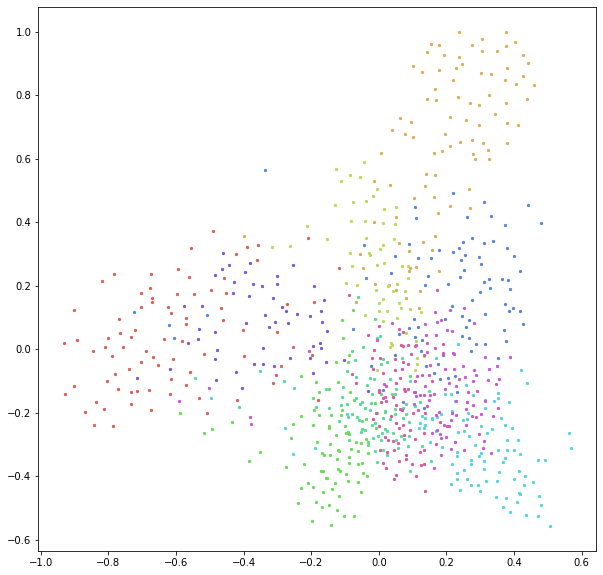

In [5]:
colors = sns.color_palette("hls", 10)
plt.figure(figsize=(10,10))
for i in range(n):
  plt.scatter(pos[i][0], pos[i][1], c=[colors[labels[i][1]-1]], s=5)

#Preprocessing

In [6]:
def stats(G):
  degrees = []
  for node in G.nodes:
    degrees.append(G.degree(node))

  similarities = []
  for edge in G.edges:
    sim = G.get_edge_data(*edge)['weight']
    similarities.append(sim)
  
  similarities = np.array(similarities)

  fig, axs = plt.subplots(2, figsize=(20,10))
  axs[0].hist(degrees, bins=50)
  axs[1].hist(similarities, bins=50)

  print(f'Average degree: {np.mean(degrees)}, min degree: {np.min(degrees)}, max degree: {np.max(degrees)}')
  print(f'Average similarity: {np.mean(similarities)}, min similarity: {np.amin(similarities[similarities!=np.amin(similarities)])}, max similarity: {np.max(similarities)}')

Average degree: 208.0, min degree: 33, max degree: 530
Average similarity: 0.06114701728920119, min similarity: 0.015051, max similarity: 1.548657


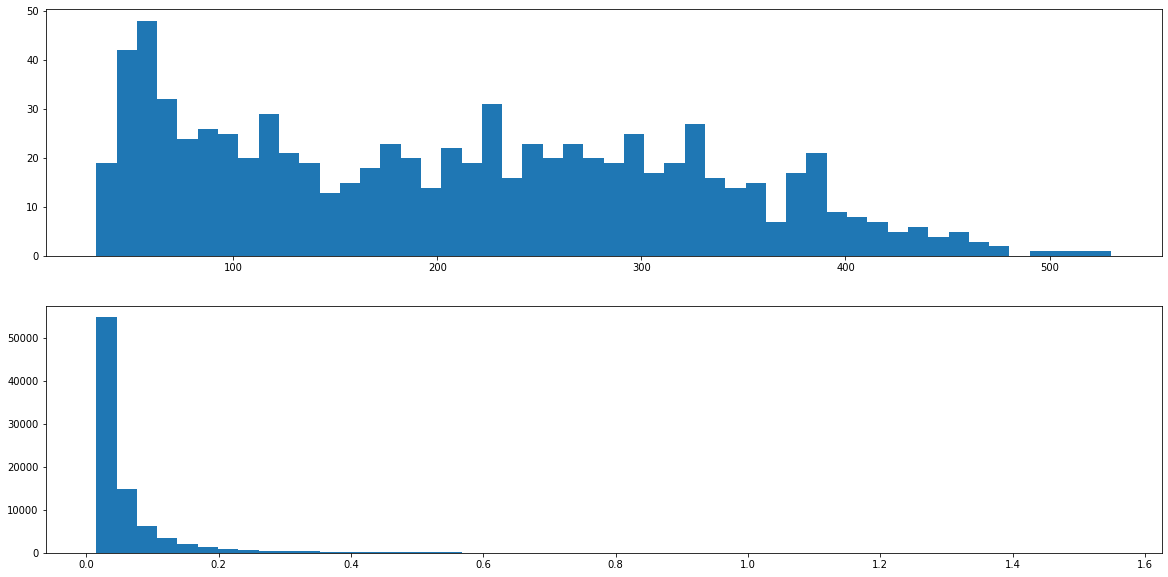

In [7]:
stats(G)

Sparsify the graph:

In [8]:
"""
  if len(sorted_edges_by_weight)>m:
    for i in range(len(sorted_edges_by_weight)):
      edge = sorted_edges_by_weight[i]

      if G.get_edge_data(*edge)['weight']<epsilon and len(G.edges(edge[1]))>m and len(G.edges(edge[0]))>m:
        G.remove_edge(*edge)

      if G.number_of_edges == m:
        break
  """

"\n  if len(sorted_edges_by_weight)>m:\n    for i in range(len(sorted_edges_by_weight)):\n      edge = sorted_edges_by_weight[i]\n\n      if G.get_edge_data(*edge)['weight']<epsilon and len(G.edges(edge[1]))>m and len(G.edges(edge[0]))>m:\n        G.remove_edge(*edge)\n\n      if G.number_of_edges == m:\n        break\n  "

In [9]:
epsilon = 0.1
m = 1

In [10]:
G = nx.read_weighted_edgelist('SS-Butterfly_weights.tsv', nodetype=int)

for epoch in range(10):

  for i in G.nodes:
    #sort edges in reverse (decreasing weight)
    sorted_edges_by_weight_i = sorted(G.edges(i), key=lambda edge: G.get_edge_data(*edge)['weight'], reverse=True)

    len_edges_i = len(sorted_edges_by_weight_i)
    
    for edge_i in sorted_edges_by_weight_i[:m]:
      j = edge_i[1]

      sorted_edges_by_weight_j = sorted(G.edges(j), key=lambda edge: G.get_edge_data(*edge)['weight'], reverse=True)
      len_edges_j = len(sorted_edges_by_weight_j)

      for edge_j in sorted_edges_by_weight_j[:m]:
        k = edge_j[1]
        if k!=i:
          wij = G.get_edge_data(i,j)['weight']
          wjk = G.get_edge_data(j,k)['weight']
          G.add_edge(i,k, weight=max(wij,wjk))

  for node in G.nodes:
    #get edges surrounding node (increasing order in weight)
    sorted_edges_by_weight = sorted(G.edges(node), key=lambda edge: G.get_edge_data(*edge)['weight'])
    
    for i in range(len(sorted_edges_by_weight)):
      edge = sorted_edges_by_weight[i]

      if G.get_edge_data(*edge)['weight']<epsilon:
        G.remove_edge(*edge)
    
  


Average degree: 29.264423076923077, min degree: 2, max degree: 117
Average similarity: 0.2640155499425004, min similarity: 0.100004, max similarity: 1.548657


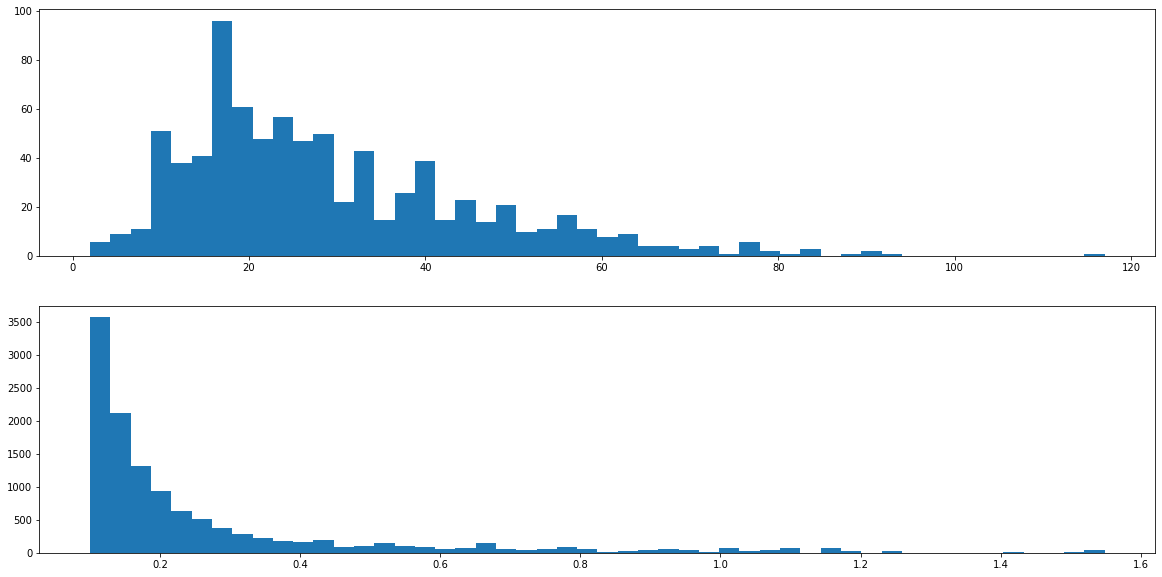

In [11]:
stats(G)

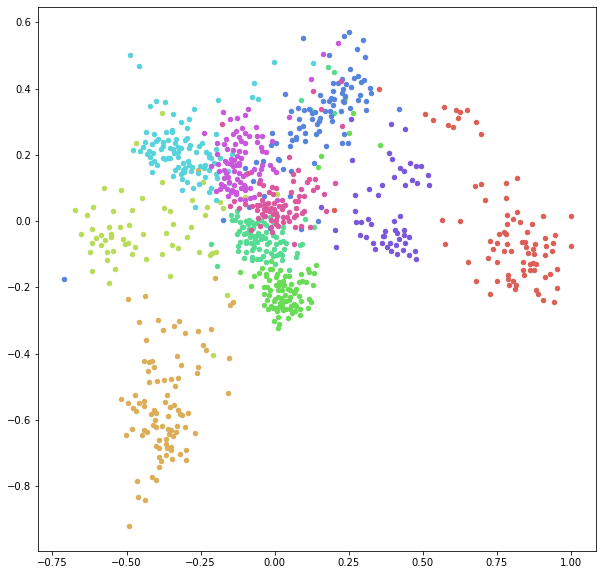

In [12]:
pos=nx.spring_layout(G)

plt.figure(figsize=(10,10))
for i in range(n):
  plt.scatter(pos[i][0], pos[i][1], c=[colors[labels[i][1]-1]], s=20)

In [13]:
pos_spectral = nx.spectral_layout(G)

#Spectral clustering

Generalized eigensystem is of the form: $Lu=\lambda Du$

This is equivalent to: $D^{-1}Lu=\lambda u$

So define the normalized Laplacian as $L_{norm}=D^{-1}L$ and find its eigenvalues

In [14]:
L_norm = nx.normalized_laplacian_matrix(G)

#Compute eigenvalues of L_norm
eigvals, eigvecs = np.linalg.eig(L_norm.toarray())

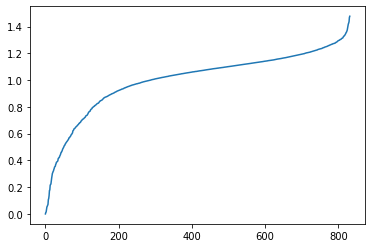

In [15]:
sorted_eigvals = np.sort(eigvals)
plt.plot(sorted_eigvals)

Use eigengap heuristic: (maximize discrepancy)

In [16]:
discrepancies = sorted_eigvals[1:] - sorted_eigvals[:-1]

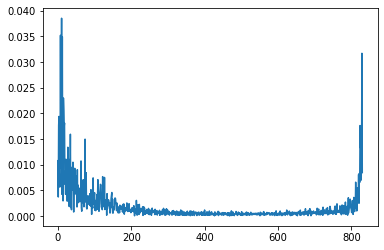

In [17]:
plt.plot(discrepancies)

We ignore the tail since we prefer small number of clusters:

In [18]:
K = np.argmax(discrepancies[:400])
print(K)

10


In [19]:
from sklearn.cluster import SpectralClustering
from scipy.spatial import distance_matrix

In [20]:
"""
pos_array=np.array(list(pos.values()))

d_matrix = distance_matrix(pos_array, pos_array)

affinity=np.exp(-d_matrix**2)
"""

'\npos_array=np.array(list(pos.values()))\n\nd_matrix = distance_matrix(pos_array, pos_array)\n\naffinity=np.exp(-d_matrix**2)\n'

In [21]:
affinity = nx.adjacency_matrix(G).toarray()

sc = SpectralClustering(n_clusters=K, affinity='precomputed').fit(affinity)
sc.labels_
#sc_labels = spectral_clustering(n_clusters=K, affinity=affinity, eigen_solver='arpack', n_init=100)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 6, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 8, 8, 4, 4, 4, 8, 4, 4,
       4, 4, 4, 4, 4, 0, 0, 5, 0, 5, 0, 3, 1, 1, 1, 5, 2, 1, 2, 3, 6, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 4, 8, 4, 8, 8, 8, 8, 8, 8,
       5, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 6, 6, 3, 3, 6, 3, 3, 3, 3, 4,
       5, 9, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 1, 2, 1, 2, 2, 6, 1,
       1, 1, 0, 2, 6, 1, 1, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 0,
       0, 0, 0, 0, 1, 1, 1, 5, 5, 5, 5, 1, 1, 5, 1, 0, 1, 5, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 7, 1, 7, 7, 7, 1, 7, 7, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 6, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 9,

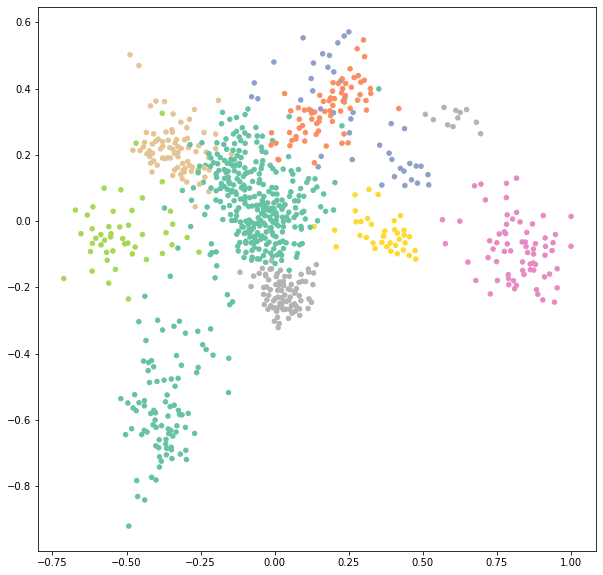

In [22]:
pos_array = np.array(list(pos.values()))
plt.figure(figsize=(10,10))
plt.scatter(pos_array[:,0], pos_array[:,1], cmap='Set2', c=sc.labels_, s=20)


Evaluation on metric:

In [23]:
from sklearn import metrics

metrics.rand_score(labels[:,1], sc.labels_)

0.7764133805424419

Spectral layout:

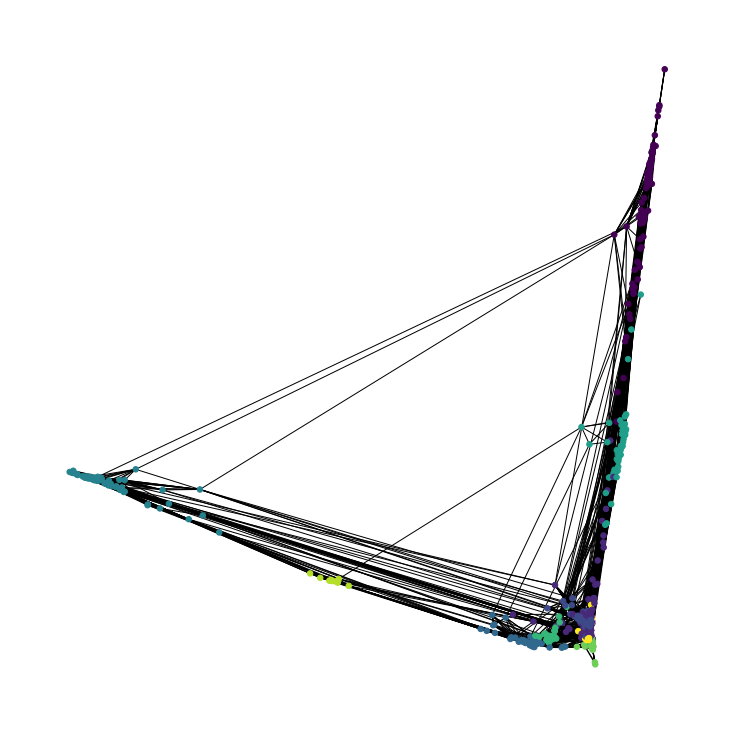

In [24]:
plt.figure(1, figsize=(10,10))
nx.draw(G, pos_spectral, node_color=sc.labels_, node_size=30)

#Agglomerative Clustering

In [25]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

The following dendrogram plotting function comes from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [26]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [27]:
model = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=0, affinity='cosine')

affinity = nx.adjacency_matrix(G).toarray()
model = model.fit(affinity)


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


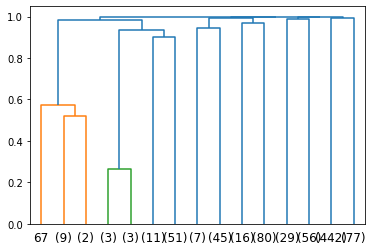

In [28]:
plot_dendrogram(model, truncate_mode="level", p=3)


Using the n_cluster selection heuristic, we see that we should select ~14 clusters.

In [33]:
model = AgglomerativeClustering(linkage='average', n_clusters=14, compute_distances=True, affinity='cosine')

model = model.fit(affinity)


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


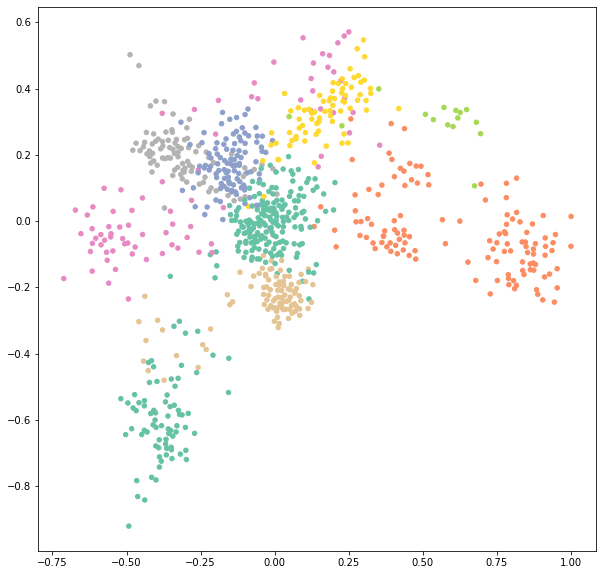

In [34]:
plt.figure(figsize=(10,10))
pos_array=np.array(list(pos.values()))

plt.scatter(pos_array[:,0], pos_array[:,1], cmap='Set2', c=model.labels_, s=20)


In [35]:
metrics.rand_score(labels[:,1], model.labels_)

0.8300645653985004

#DBSCAN

In [36]:
from sklearn.cluster import DBSCAN
import numpy as np

In [37]:
affinity = np.load('affinity.npy')

In [38]:
min_samples=5
eps=0.5

In [39]:
dbscan = DBSCAN(metric='cosine', eps=eps, min_samples=min_samples).fit(affinity)

In [40]:
np.mean(affinity)

0.009286373500485395

In [93]:
sns.color_palette("hsv", n_clusters)

[(1.0, 0.16213251507369153, 0.0),
 (1.0, 0.34742681801505326, 0.0),
 (1.0, 0.532721120956415, 0.0),
 (1.0, 0.7180154238977768, 0.0),
 (1.0, 0.8801479389714684, 0.0),
 (0.93455775808717, 1.0, 0.0),
 (0.7492634551458082, 1.0, 0.0),
 (0.5639691522044463, 1.0, 0.0),
 (0.4018366371307548, 1.0, 0.0),
 (0.21654233418939306, 1.0, 0.0),
 (0.03124934374934376, 1.0, 1.3125013124790507e-06),
 (0.0, 1.0, 0.15404569495487538),
 (0.0, 1.0, 0.3161771885991356),
 (0.0, 1.0, 0.5014703241925758),
 (0.0, 1.0, 0.6867634597860162),
 (0.0, 1.0, 0.8720565953794563),
 (0.0, 0.9658116955911072, 1.0),
 (0.0, 0.7805173926497455, 1.0),
 (0.0, 0.5952230897083839, 1.0),
 (0.0, 0.40992878676702216, 1.0),
 (0.0, 0.24779627169333063, 1.0),
 (0.0, 0.062501968751969, 1.0),
 (0.12279233418939263, 0.0, 1.0),
 (0.30808663713075457, 0.0, 1.0),
 (0.47021915220444627, 0.0, 1.0),
 (0.6555134551458082, 0.0, 1.0),
 (0.8408077580871701, 0.0, 1.0),
 (0.9878673536761773, 0.0, 0.9617652926476454),
 (1.0, 0.0, 0.8117654238977766),
 (1.0, 0.0, 0.6264711209564149),
 (1.0, 0.0, 0.4411768180150532),
 (1.0, 0.0, 0.2558825150736914)]

In [50]:
import matplotlib

In [94]:
import seaborn as sns
n_clusters = len(np.unique(dbscan.labels_))
cdict = dict(zip(list(np.unique(dbscan.labels_)), [tuple(c for c in cs) for cs in sns.color_palette("hsv", n_clusters)]))

print(cdict)

{-1: (1.0, 0.16213251507369153, 0.0), 0: (1.0, 0.34742681801505326, 0.0), 1: (1.0, 0.532721120956415, 0.0), 2: (1.0, 0.7180154238977768, 0.0), 3: (1.0, 0.8801479389714684, 0.0), 4: (0.93455775808717, 1.0, 0.0), 5: (0.7492634551458082, 1.0, 0.0), 6: (0.5639691522044463, 1.0, 0.0), 7: (0.4018366371307548, 1.0, 0.0), 8: (0.21654233418939306, 1.0, 0.0), 9: (0.03124934374934376, 1.0, 1.3125013124790507e-06), 10: (0.0, 1.0, 0.15404569495487538), 11: (0.0, 1.0, 0.3161771885991356), 12: (0.0, 1.0, 0.5014703241925758), 13: (0.0, 1.0, 0.6867634597860162), 14: (0.0, 1.0, 0.8720565953794563), 15: (0.0, 0.9658116955911072, 1.0), 16: (0.0, 0.7805173926497455, 1.0), 17: (0.0, 0.5952230897083839, 1.0), 18: (0.0, 0.40992878676702216, 1.0), 19: (0.0, 0.24779627169333063, 1.0), 20: (0.0, 0.062501968751969, 1.0), 21: (0.12279233418939263, 0.0, 1.0), 22: (0.30808663713075457, 0.0, 1.0), 23: (0.47021915220444627, 0.0, 1.0), 24: (0.6555134551458082, 0.0, 1.0), 25: (0.8408077580871701, 0.0, 1.0), 26: (0.98786

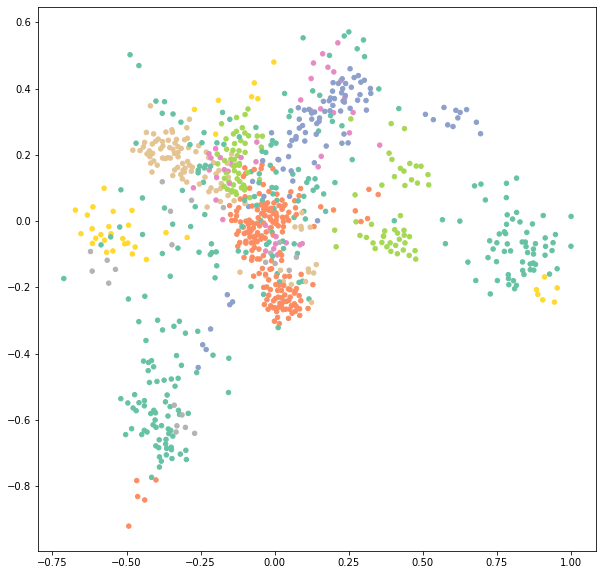

In [95]:
plt.figure(figsize=(10,10))

plt.scatter(pos_array[:,0], pos_array[:,1], cmap='Set2', c=dbscan.labels_, s=20)


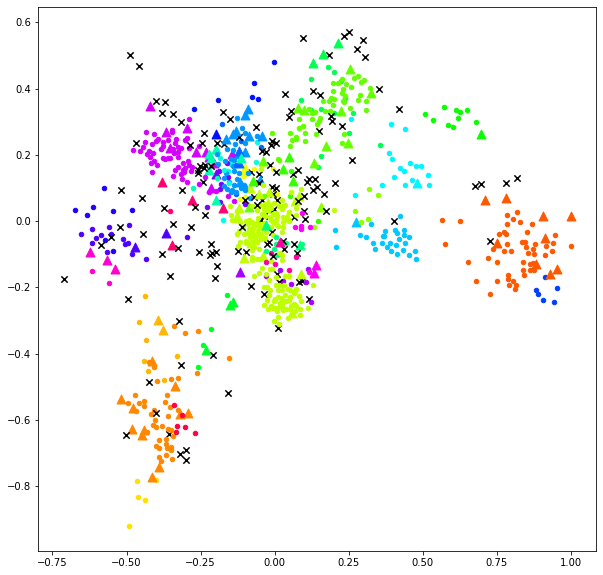

In [99]:
plt.figure(figsize=(10,10))
pos_array=np.array(list(pos.values()))

for i in range(n):
  if dbscan.labels_[i] == -1:
    plt.scatter(pos_array[i,0], pos_array[i,1], c='black', marker='x', s=40)
  elif i not in dbscan.core_sample_indices_:
    plt.scatter(pos_array[i,0], pos_array[i,1], c=matplotlib.colors.to_hex(cdict[dbscan.labels_[i]]), marker='^', s=80)
  else:
    plt.scatter(pos_array[i,0], pos_array[i,1], c=matplotlib.colors.to_hex(cdict[dbscan.labels_[i]]), marker='.', s=80)



In [100]:
metrics.rand_score(labels[:,1], dbscan.labels_)

0.8358760298065352